In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from tableone import TableOne
# from matplotlib.font_manager import FontProperties
from scipy.stats import zscore
import seaborn as sns
from matplotlib.ticker import MaxNLocator

## Seasonal changes in weather conditions across sites (Figure 2)

In [2]:
def assign_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

<Figure size 1500x1800 with 0 Axes>

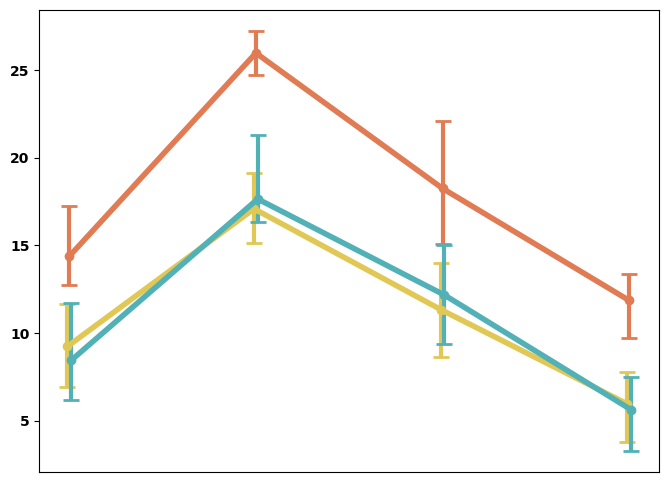

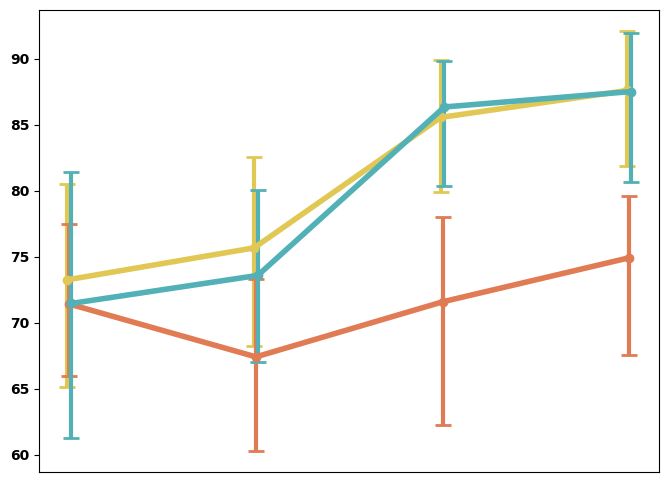

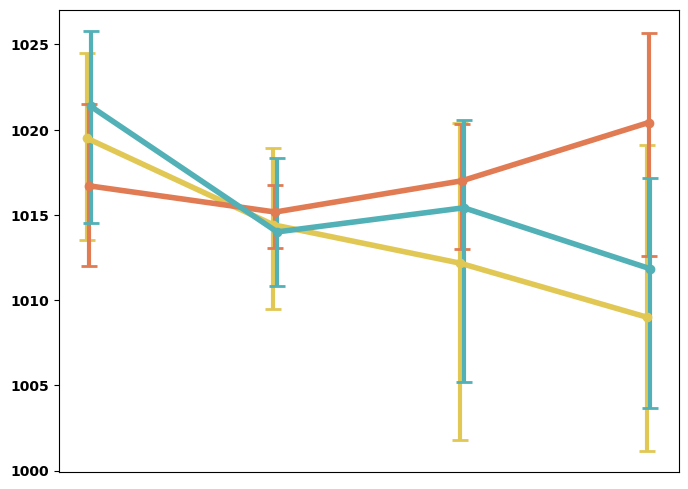

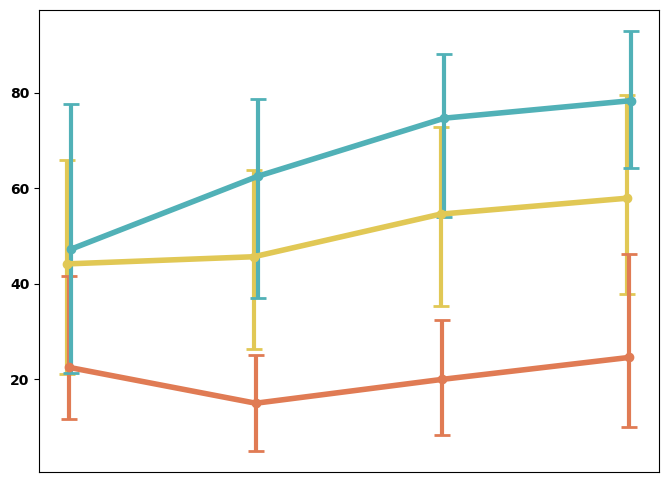

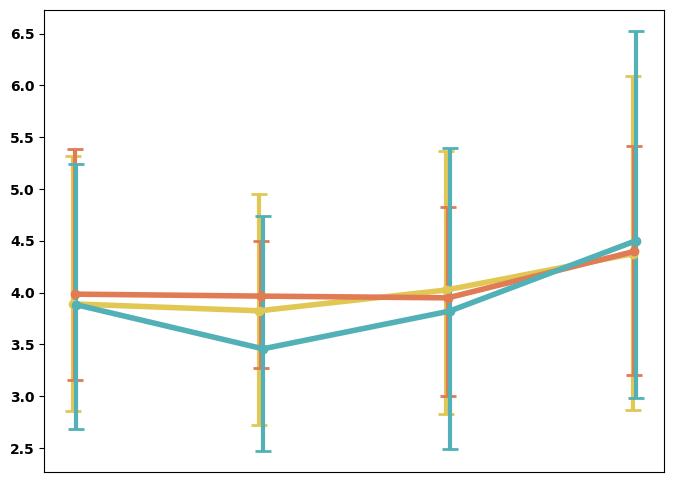

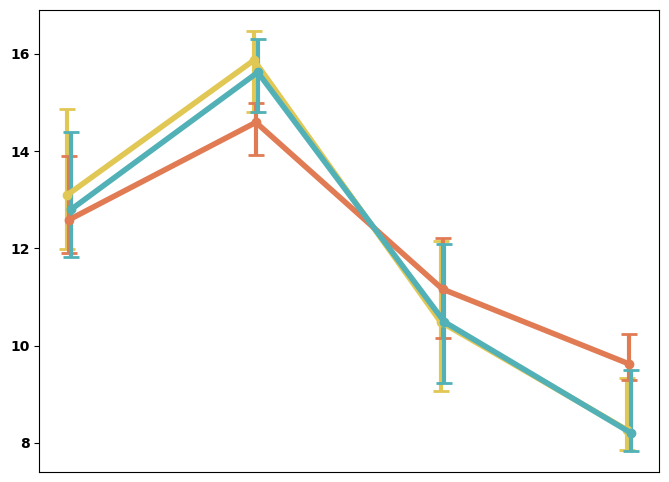

In [3]:
# load weather data
phq_weather_df = pd.read_csv('/Users/yuezhou/Documents/Work/Data/MDD_Weather/processed_data/analysis_data/phq_weather_selected.csv')
# load city information
city_set_df = pd.read_csv('/Users/yuezhou/Documents/Work/Data/MDD_Weather/processed_data/analysis_data/city_set.csv')

# Selecting relevant columns from the weather dataset and converting 'dt' to datetime
weather_cols = ['city', 'dt', 'temp_mean', 'humidity_mean', 'pressure_mean', 'clouds_mean', 'wind_speed_mean', 'sun_diff']
phq_weather_selected_df = phq_weather_df[weather_cols]
phq_weather_selected_df['dt'] = pd.to_datetime(phq_weather_selected_df['dt'])

# Apply the function to create a 'season' column
phq_weather_selected_df['month'] = phq_weather_selected_df['dt'].dt.month
phq_weather_selected_df['season'] = phq_weather_selected_df['month'].apply(assign_season)

# Merging the city set data with the weather data
merged_data = pd.merge(city_set_df, phq_weather_selected_df, on='city')

# Filtering data for specific countries: United Kingdom, Spain, Netherlands
countries_of_interest = ['United Kingdom', 'Spain', 'Netherlands']
filtered_data = merged_data[merged_data['country'].isin(countries_of_interest)]

# Removing duplicates based on 'city' and 'dt'
filtered_data_cleaned = filtered_data.drop_duplicates(subset=['city', 'dt'])

# Convert temperature from Kelvin to Celsius
filtered_data_cleaned['temp_mean_celsius'] = filtered_data_cleaned['temp_mean'] - 273.15

# Weather variables of interest
weather_vars = ['temp_mean_celsius', 'humidity_mean', 'pressure_mean', 'clouds_mean', 'wind_speed_mean', 'sun_diff']

# Function to calculate median and IQR for each weather variable
def calculate_median_iqr(data, group_vars, target_var):
    grouped = data.groupby(group_vars)[target_var].describe(percentiles=[.25, .5, .75])
    return grouped[['50%', '25%', '75%']].rename(columns={'50%': 'Median', '25%': 'Q1', '75%': 'Q3'})

# Calculating median and IQR for each variable
weather_stats = {var: calculate_median_iqr(filtered_data_cleaned, ['country', 'season'], var) for var in weather_vars}

plt.figure(figsize=(15, 18))
seasons_ordered = ['Spring', 'Summer', 'Autumn', 'Winter']
figure_titles = ['Temperature', 'Humidity', 'Pressure', 'Cloudiness', 'Wind Speed', 'Daylength']
figure_units = ['Celsius', "Percentage", 'hPa', 'Percentage', 'Meter/Sec', 'Hour']
country_colors = {
    'United Kingdom': '#E1C855',
    'Spain': '#E07B54',
    'Netherlands': '#51B1B7'
}

for i, variable in enumerate(weather_vars):
    plt.figure(figsize=(8,6))
    for country_idx, country in enumerate(countries_of_interest):
        country_data = weather_stats[variable].xs(country, level='country').reindex(seasons_ordered)
        median_values = country_data['Median']
        error_lower = median_values - country_data['Q1']
        error_upper = country_data['Q3'] - median_values
        x_shifted = [seasons_ordered.index(season) + country_idx * 0.01 for season in seasons_ordered]
        plt.errorbar(x_shifted, median_values, yerr=[error_lower, error_upper], label=country, fmt='-o', capsize=6,  capthick=2, color=country_colors[country], linewidth=4, elinewidth=3)

    plt.ylabel("", fontweight='bold')
    plt.xlabel("")
    plt.xticks([])
    plt.yticks(fontweight='bold')
    plt.show()

## PHQ8 seasonal changes

### Load data

In [4]:
# load weather 
weather_phq = pd.read_csv("/Users/yuezhou/Documents/Work/Data/MDD_Weather/processed_data/analysis_data/phq_weather.csv")
participant_record_counts = weather_phq['p_id'].value_counts()
participants_with_at_least_two_records = participant_record_counts[participant_record_counts >= 2].index.tolist()
# load phq8
file_path = '/Users/yuezhou/Documents/Work/Data/MDD_Weather/processed_data/analysis_data/phq8.csv'
data = pd.read_csv(file_path)
# load demographics
demo = pd.read_csv('/Users/yuezhou/Documents/Work/Data/MDD_Weather/processed_data/analysis_data/demo.csv')
data = data[data['p_id'].isin(participants_with_at_least_two_records)]
data = data[data['p_id'].isin(demo['p_id'].values)]

In [5]:
# assign seasons
data['dt'] = pd.to_datetime(data['dt'])
data['month'] = data['dt'].dt.month
data['season'] = data['month'].apply(assign_season)
# sort seasons
data['season'] = pd.Categorical(data['season'], categories=['Spring', 'Summer', 'Autumn', 'Winter'], ordered=True)
seasonal_scores = data.groupby(['p_id', 'season'])['sum_phq8'].mean().reset_index()
pivot_data = seasonal_scores.pivot(index='p_id', columns='season', values='sum_phq8')
pivot_data = pivot_data.dropna()  
pivot_data_centered = pivot_data.subtract(pivot_data.mean(axis=1), axis=0)
print(pivot_data_centered.shape) 
pivot_data_centered.head()

(428, 4)


season,Spring,Summer,Autumn,Winter
p_id,,,,
007751c5-d7ad-4bec-a58f-abf32500e2ae,0.435096,-0.689904,-0.439904,0.694712
00d1d60a-15cf-481b-8264-91705b6f8d97,0.431568,0.900100,-0.022977,-1.308691
0104dfff-4dcd-48ff-b912-51362f098ed0,-1.529457,-1.490995,3.192766,-0.172314
0157930f-10f7-4d5f-9575-a65efbd1d505,0.393434,-3.495455,3.241919,-0.139899
02640ba3-a078-4bef-8854-87f71905a1a3,0.354167,-0.395833,-0.562500,0.604167


### Perform Kmeans

Using Elbow method to determine the optimal K

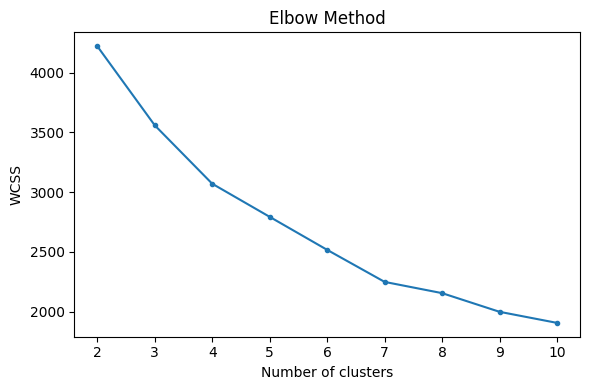

In [6]:
wcss = []
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=1).fit(pivot_data_centered.iloc[:, :4])
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pivot_data_centered.iloc[:, :4], kmeans.labels_))

plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), wcss, '.-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.tight_layout()
plt.show()

In [7]:
# run kmeans
kmeans_centered = KMeans(n_clusters=4, init='k-means++', max_iter=500, n_init=100, random_state=2).fit(pivot_data_centered.iloc[:, :4])
pivot_data_centered['cluster'] = kmeans_centered.labels_
cluster_sizes = pivot_data_centered['cluster'].value_counts()
sorted_clusters = cluster_sizes.sort_values(ascending=False).index
cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters, start=0)}
# Apply the mapping to the original DataFrame to create a new column with updated cluster labels
pivot_data_centered['cluster'] = pivot_data_centered['cluster'].map(cluster_mapping)
# link phq8 and demographics
cluster_results = pivot_data_centered[['cluster']]
cluster_results = cluster_results.reset_index()
cluster_results['mean_PHQ8'] = pivot_data.mean(axis=1).values
cluster_results = pd.merge(cluster_results, demo, on='p_id', how='left')
cluster_results['cluster'] = cluster_results['cluster']  + 1
# calculate baseline phq8
base_phq = data.sort_values(by=['p_id', 'dt']).groupby('p_id').first().reset_index()
base_phq = base_phq[['p_id', 'sum_phq8']].rename(columns={'sum_phq8': 'base_phq8'})
cluster_results = cluster_results.merge(base_phq, on= 'p_id', how= 'left')

### Compare demographics and PHQ-8 across clusters

In [8]:
cluster_results['income_align'] = pd.Categorical(cluster_results['income_align'], categories=['below minimum','15,000-55,000', 'more than 55000','prefer not to say', 'unknown'], ordered=True)
cluster_results['employment'] = pd.Categorical(cluster_results['employment'], categories=['Yes', 'No', 'Not reported'], ordered=True)
cluster_results['children'] = pd.Categorical(cluster_results['children'], categories=['Yes', 'No'], ordered=True)
cluster_results['marry_align'] = pd.Categorical(cluster_results['marry_align'], categories=['Single/separated/divorced/widowed', 'Married/cohabiting/Long term relationship'], ordered=True)
columns = ['cluster','mean_PHQ8', 'base_phq8','age', 'edu_age_align', 'sex', 'employment','children','marry_align','income_align', 'site']
catergorical = ['sex','site','marry_align','children','income_align', 'employment']
groupby = 'cluster'          
nonnormal = ['age','edu_age_align','mean_PHQ8', 'base_phq8']
table = TableOne(cluster_results, columns = columns,categorical=catergorical, groupby= groupby, nonnormal=nonnormal, pval=True)
print(table)

                                                                        Grouped by cluster                                                                                                  
                                                                                   Missing           Overall                 1                 2                 3                 4 P-Value
n                                                                                                        428               199                93                73                63        
mean_PHQ8, median [Q1,Q3]                                                                0    9.5 [6.0,13.7]    8.6 [4.9,12.2]   10.8 [7.6,15.2]    9.7 [7.0,14.4]   10.7 [7.9,13.9]   0.002
base_phq8, median [Q1,Q3]                                                                0   10.0 [6.0,15.0]    9.0 [6.0,13.0]   13.0 [8.0,16.0]   11.0 [6.0,16.0]   10.0 [6.0,15.0]   0.003
age, median [Q1,Q3]                                    

Figure 3e

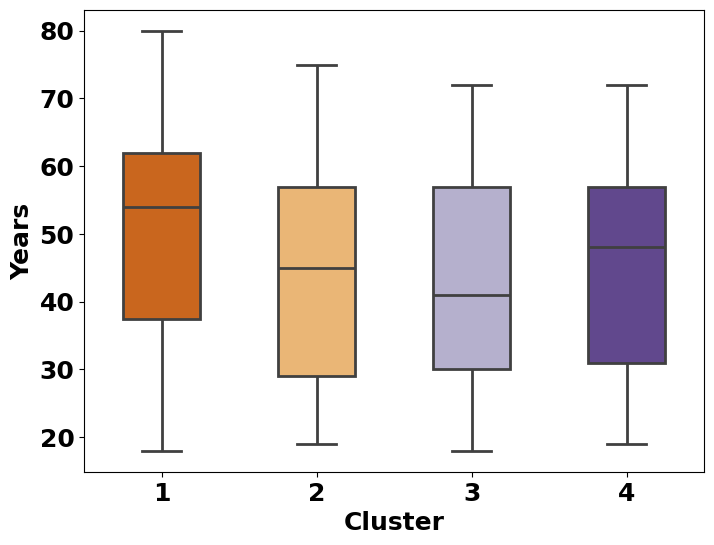

In [9]:
custom_palette = ["#e66101", "#fdb863", "#b2abd2", "#5e3c99"]
# Age across 4 clusters
plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster', y='age', data=cluster_results, palette=custom_palette, width=0.5,
            linewidth=2, showfliers=False)  # Adjusted box width to be narrower
plt.xlabel('Cluster', fontsize=18, weight='bold')
plt.ylabel('Years', fontsize=18, weight='bold')
plt.xticks(fontweight='bold', fontsize=18)
plt.yticks(fontweight='bold', fontsize=18)
plt.show()

Figure 3f

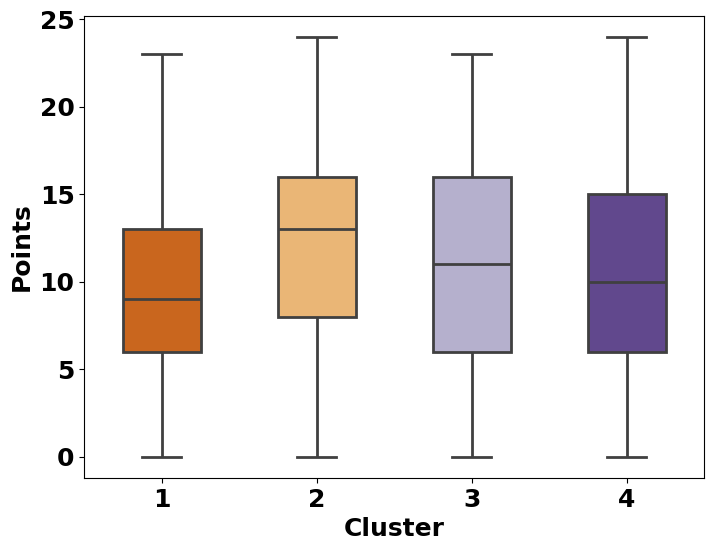

In [10]:
# Baseline PHQ-8 across 4 clusters
plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster', y='base_phq8', data=cluster_results, palette=custom_palette, width=0.5,
            linewidth=2, showfliers=False)  
plt.xlabel('Cluster', fontsize=18, weight='bold')
plt.ylabel('Points', fontsize=18, weight='bold')
plt.xticks(fontweight='bold', fontsize=18)
plt.yticks(fontweight='bold', fontsize=18)
plt.show()

### Summary of Demographics

Demographics across 3 study sites (Table 1)

In [11]:
# summarize demo of all selected participants and across sites
columns = ['mean_PHQ8', 'base_phq8','age', 'edu_age_align', 'sex', 'employment','children','marry_align','income_align', 'site']
catergorical = ['sex','marry_align','children','income_align', 'employment']
groupby = 'site'
nonnormal = ['mean_PHQ8', 'base_phq8','age','edu_age_align']
table = TableOne(cluster_results, columns = columns,categorical=catergorical, groupby= groupby, nonnormal=nonnormal, pval=True)
print(table)

                                                                        Grouped by site                                                                                
                                                                                Missing           Overall             ciber               kcl              vumc P-Value
n                                                                                                     428                90               251                87        
mean_PHQ8, median [Q1,Q3]                                                             0    9.5 [6.0,13.7]   13.4 [8.6,17.5]    8.9 [5.5,12.5]    9.1 [6.1,11.9]  <0.001
base_phq8, median [Q1,Q3]                                                             0   10.0 [6.0,15.0]  14.5 [10.0,18.8]    9.0 [6.0,13.0]    8.0 [6.0,13.0]  <0.001
age, median [Q1,Q3]                                                                   0  50.0 [32.0,60.0]  55.0 [45.5,61.0]  47.0 [31.0,59.0]  40.0 [26.5,58.5] 

Sensitivity analysis - compare selected participants with the whole RADAR-MDD cohort (Supplementary Table 1)

In [12]:
all_participant = pd.read_csv('/Users/yuezhou/Documents/Work/Data/MDD_Weather/processed_data/demographics_harmonized_623.csv')
all_phq8 = pd.read_csv(file_path)

all_participant['income_align'] = pd.Categorical(all_participant['income_align'], categories=['below minimum','15,000-55,000', 'more than 55000','prefer not to say', 'unknown'], ordered=True)
all_participant['employment'] = pd.Categorical(all_participant['employment'], categories=['Yes', 'No', 'Not reported'], ordered=True)
all_participant['children'] = pd.Categorical(all_participant['children'], categories=['Yes', 'No'], ordered=True)
all_participant['marry_align'] = pd.Categorical(all_participant['marry_align'], categories=['Single/separated/divorced/widowed', 'Married/cohabiting/Long term relationship'], ordered=True)
all_participant['selected'] = 0
all_participant['selected'][all_participant['p_id'].isin(cluster_results['p_id'].values)] = 1
columns = ['age', 'edu_age_align', 'sex', 'employment','children','marry_align','income_align', 'site']
catergorical = ['sex','site','marry_align','children','income_align', 'employment']
groupby = 'selected'          
nonnormal = ['age','edu_age_align']
table = TableOne(all_participant, columns = columns,categorical=catergorical, groupby= groupby, nonnormal=nonnormal, pval=True)

print(table)

                                                                        Grouped by selected                                                              
                                                                                    Missing           Overall                 0                 1 P-Value
n                                                                                                         623               195               428        
age, median [Q1,Q3]                                                                       0  49.0 [32.0,59.0]  49.0 [33.5,56.5]  50.0 [32.0,60.0]   0.336
edu_age_align, median [Q1,Q3]                                                             0  16.0 [13.0,19.0]  15.0 [13.0,18.0]  16.0 [13.0,19.0]   0.358
sex, n (%)                    female                                                               471 (75.6)        140 (71.8)        331 (77.3)   0.164
                              male                                          

### Plot 4 clusters of seasonal depression variations with physical activity (steps) (Figure 3)

In [13]:
# remove outliers
filtered_data_per_cluster = pd.DataFrame(columns=pivot_data_centered.columns)
# Loop through each cluster to filter out outliers based on Z-score within that cluster
for i in range(4):
    cluster_data = pivot_data_centered[pivot_data_centered['cluster'] == i].copy()
    z_scores_cluster = np.abs(zscore(cluster_data.iloc[:, :-1]))  # Calculate Z-score excluding the 'cluster' column
    cluster_data['is_outlier'] = (z_scores_cluster > 2).any(axis=1)  # Identify outliers within the cluster
    filtered_cluster_data = cluster_data[~cluster_data['is_outlier']]  # Exclude outliers
    filtered_data_per_cluster = pd.concat([filtered_data_per_cluster, filtered_cluster_data])

step_data = pd.read_csv('/Users/yuezhou/Documents/Work/Data/MDD_Weather/processed_data/analysis_data/phq8_features.csv')
step_data['time_str'] = pd.to_datetime(step_data['time_str'])
step_data['month'] = step_data['time_str'].dt.month
step_data['season'] = step_data['month'].apply(assign_season)
step_data['season'] = pd.Categorical(step_data['season'], categories=['Spring', 'Summer', 'Autumn', 'Winter'], ordered=True)
cluster_labels = pivot_data_centered[['cluster']]

step_data_centered = step_data.copy()
step_data_centered['mean_step_centered'] = step_data.groupby('p_id')['step_all_mean'].transform(lambda x: x - x.mean())
merged_centered_data = pd.merge(step_data_centered, cluster_labels, on='p_id')


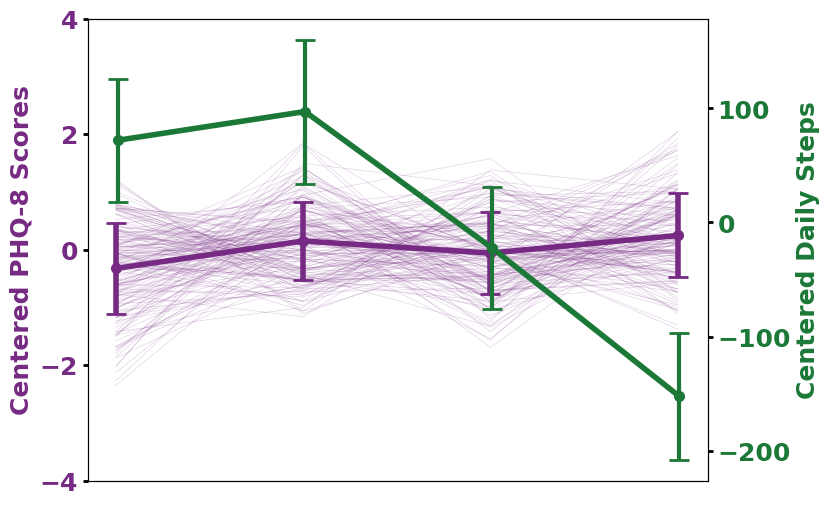

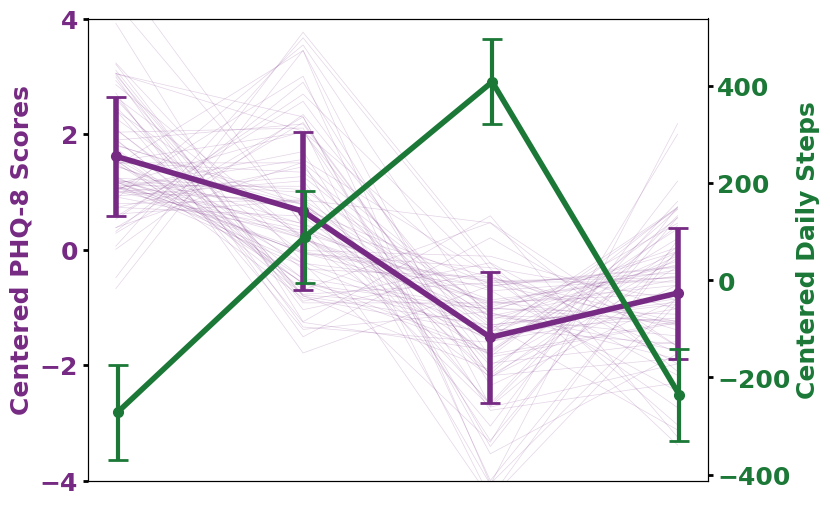

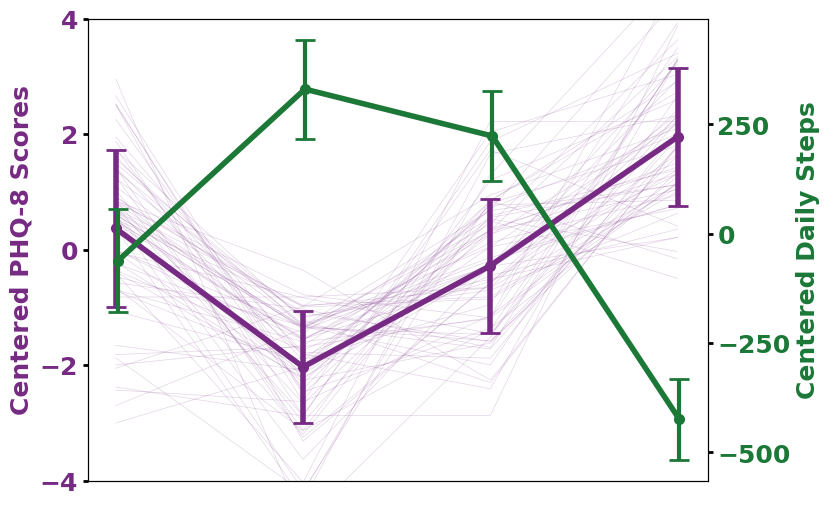

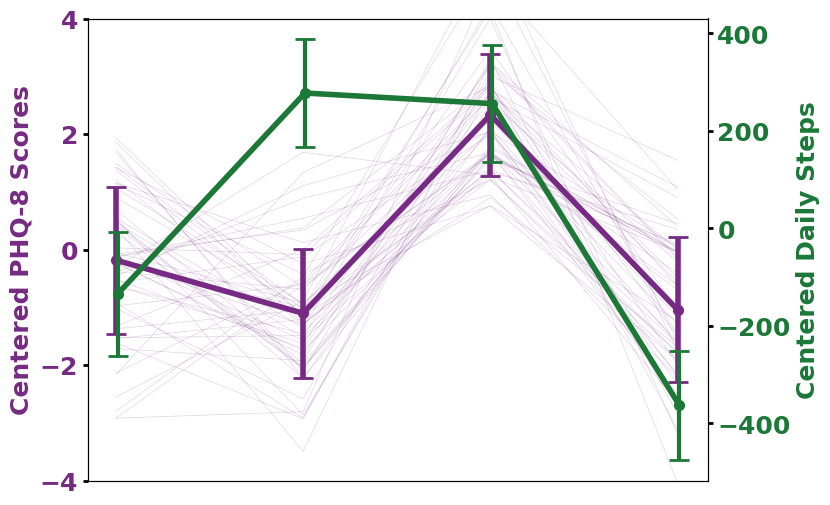

In [14]:
def calculate_se(group):
    return group.std() / np.sqrt(group.count())
def calculate_iqr(group):
    return group.quantile(0.75) - group.quantile(0.25)

seasonal_step_means = merged_centered_data.groupby(['cluster', 'season'])['mean_step_centered'].mean().reset_index()
seasonal_step_se = merged_centered_data.groupby(['cluster', 'season'])['mean_step_centered'].apply(calculate_se).reset_index()

seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
# Visualization with separate plots for each cluster
for i in range(4):
    # Select the data for the current cluster
    cluster_step_mean = seasonal_step_means[seasonal_step_means['cluster']==i]['mean_step_centered']
    cluster_step_se = seasonal_step_se[seasonal_step_se['cluster']==i]['mean_step_centered']
    
    fig, ax1 = plt.subplots(figsize=(8, 6))
    # First axis for the scores
    ax1.set_xlabel('')
    ax1.set_ylabel('Centered PHQ-8 Scores', color='#762a83', fontsize=18, fontweight='bold')
    x_shifted = [seasons.index(season) for season in seasons]
    cluster_data_filtered = filtered_data_per_cluster[filtered_data_per_cluster['cluster'] == i]
    for index, row in cluster_data_filtered.iterrows():
        ax1.plot(x_shifted, row[:-2], color='#762a83', alpha=0.2, linewidth=0.5)  # Exclude 'cluster' and 'is_outlier'
    
    # Calculate mean and std for the filtered data within the cluster
    cluster_means_filtered = cluster_data_filtered.iloc[:, :-2].mean()
    cluster_stds_filtered = cluster_data_filtered.iloc[:, :-2].std()
    x_shifted2 = [seasons.index(season) + 0.01 for season in seasons]
    # Plot the cluster's mean seasonal scores with error bars (after filtering within the cluster)
    #ax1.plot(seasons,cluster_means_filtered, color='black', linewidth=3, marker='o')
    ax1.errorbar(x_shifted, cluster_means_filtered, yerr=cluster_stds_filtered, color='#762a83', linewidth=4,
                    capsize=7, capthick=2,marker='o', markersize=7)
    
    ax1.tick_params(axis='y', labelcolor='#762a83', width=2,labelsize=18)
    ax1.set_ylim(-4, 4)
    ax1.yaxis.set_major_locator(MaxNLocator(5))
    # Second axis for the steps
    ax2 = ax1.twinx()
    ax2.set_ylabel('Centered Daily Steps', color='#1b7837', fontsize=18, fontweight='bold')
    #ax2.plot(seasons, cluster_step_mean, color='blue', linewidth=3, marker='o')
    ax2.errorbar(x_shifted2, cluster_step_mean, yerr=cluster_step_se, color='#1b7837', linewidth=4,elinewidth=3,
                    capsize=7,capthick=2, marker='o', markersize=7)
    
    ax2.tick_params(axis='y', labelcolor='#1b7837', width=2, labelsize=18)
    for label in ax2.get_yticklabels():
        label.set_fontweight('bold')
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')
    ax2.yaxis.set_major_locator(MaxNLocator(5))
    plt.xticks([])
    plt.show()


### Clustering and plots on each study site

In [15]:
kcl_set = pivot_data_centered[pivot_data_centered.index.isin(demo['p_id'][demo['site']=='kcl'])]
ciber_set = pivot_data_centered[pivot_data_centered.index.isin(demo['p_id'][demo['site']=='ciber'])]
vumc_set = pivot_data_centered[pivot_data_centered.index.isin(demo['p_id'][demo['site']=='vumc'])]

In [16]:
def elbow_plot(pivot_data_centered,randon_i):
    wcss = []
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, random_state=randon_i).fit(pivot_data_centered.iloc[:, :4])
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(pivot_data_centered.iloc[:, :4], kmeans.labels_))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, 11), wcss, '.-')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.subplot(1, 2, 2)
    plt.plot(range(2, 11), silhouette_scores, '.-')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.show()

In [17]:
kcl_step = step_data_centered[step_data_centered['p_id'].isin(demo['p_id'][demo['site']=='kcl'])]
ciber_step = step_data_centered[step_data_centered['p_id'].isin(demo['p_id'][demo['site']=='ciber'])]
vumc_step = step_data_centered[step_data_centered['p_id'].isin(demo['p_id'][demo['site']=='vumc'])]

In [ ]:
def kmean_plot(pivot_data_centered, step_data_centered,k, ll,hl):
    kmeans_centered = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=100, random_state=6).fit(pivot_data_centered.iloc[:, :4])
    pivot_data_centered['cluster'] = kmeans_centered.labels_
    cluster_sizes = pivot_data_centered['cluster'].value_counts()
    print(cluster_sizes)
    sorted_clusters = cluster_sizes.sort_values(ascending=False).index
    cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters, start=0)}
    # Apply the mapping to the original DataFrame to create a new column with updated cluster labels
    pivot_data_centered['cluster'] = pivot_data_centered['cluster'].map(cluster_mapping)
    cluster_labels = pivot_data_centered['cluster']
    merged_centered_data = pd.merge(step_data_centered, cluster_labels, on='p_id')
    seasonal_step_means = merged_centered_data.groupby(['cluster', 'season'])['mean_step_centered'].mean().reset_index()
    seasonal_step_se = merged_centered_data.groupby(['cluster', 'season'])['mean_step_centered'].apply(calculate_se).reset_index()
    
    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
    for i in range(k):
        cluster_step_mean = seasonal_step_means[seasonal_step_means['cluster']==i]['mean_step_centered']
        cluster_step_se = seasonal_step_se[seasonal_step_se['cluster']==i]['mean_step_centered']
        fig, ax1 = plt.subplots(figsize=(8, 6))
        # First axis for the scores
        ax1.set_xlabel('')
        ax1.set_ylabel('Centered PHQ-8 Scores', color='#762a83', fontsize=14, fontweight='bold')
        x_shifted = [seasons.index(season) for season in seasons]
        cluster_data_filtered = pivot_data_centered[pivot_data_centered['cluster'] == i]
        for index, row in cluster_data_filtered.iterrows():
            ax1.plot(x_shifted, row[:-1], color='#762a83', alpha=0.2, linewidth=0.5)  # Exclude 'cluster' and 'is_outlier'
        
        # Calculate mean and std for the filtered data within the cluster
        cluster_means_filtered = cluster_data_filtered.iloc[:, :-1].mean()
        cluster_stds_filtered = cluster_data_filtered.iloc[:, :-1].std()
        x_shifted2 = [seasons.index(season) + 0.01 for season in seasons]
        # Plot the cluster's mean seasonal scores with error bars (after filtering within the cluster
        ax1.errorbar(x_shifted, cluster_means_filtered, yerr=cluster_stds_filtered, color='#762a83', linewidth=4,
                        capsize=7, capthick=2,marker='o', markersize=7)
        
        ax1.tick_params(axis='y', labelcolor='#762a83', width=2)
        ax1.set_ylim(ll, hl)
        ax1.yaxis.set_major_locator(MaxNLocator(5))
        
        ax2 = ax1.twinx()
        ax2.set_ylabel('Centered Daily Steps', color='#1b7837', fontsize=14, fontweight='bold')
        ax2.errorbar(x_shifted2, cluster_step_mean, yerr=cluster_step_se, color='#1b7837', linewidth=4,elinewidth=3,
                        capsize=7,capthick=2, marker='o', markersize=7)
        
        ax2.tick_params(axis='y', labelcolor='#1b7837', width=2)
        for label in ax2.get_yticklabels():
            label.set_fontweight('bold')
        for label in ax1.get_yticklabels():
            label.set_fontweight('bold')
        ax2.yaxis.set_major_locator(MaxNLocator(5))
        plt.xticks([])    
        plt.show()
    

#### KCL (UK)

cluster
0    119
1     54
3     53
2     25
Name: count, dtype: int64


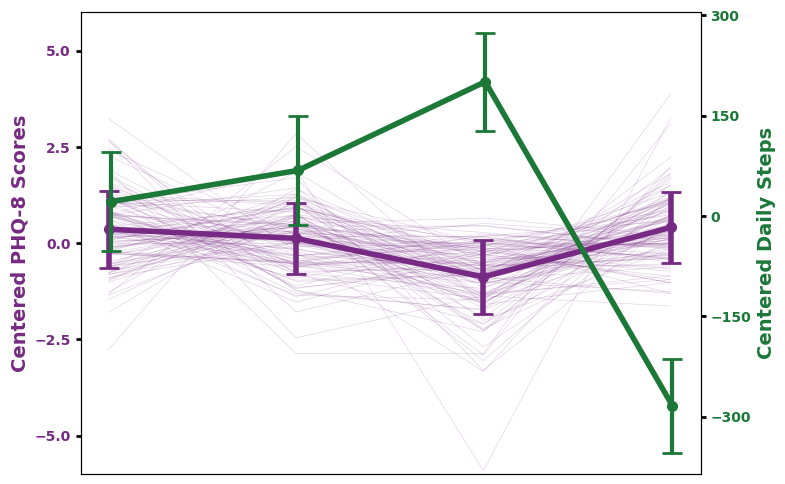

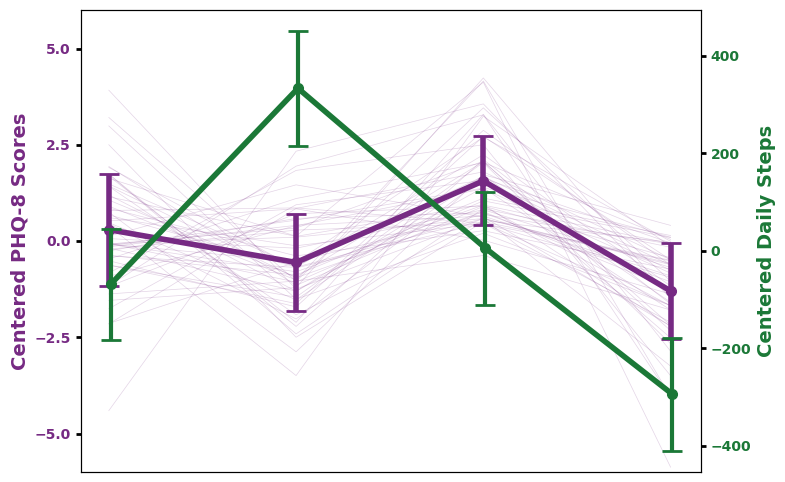

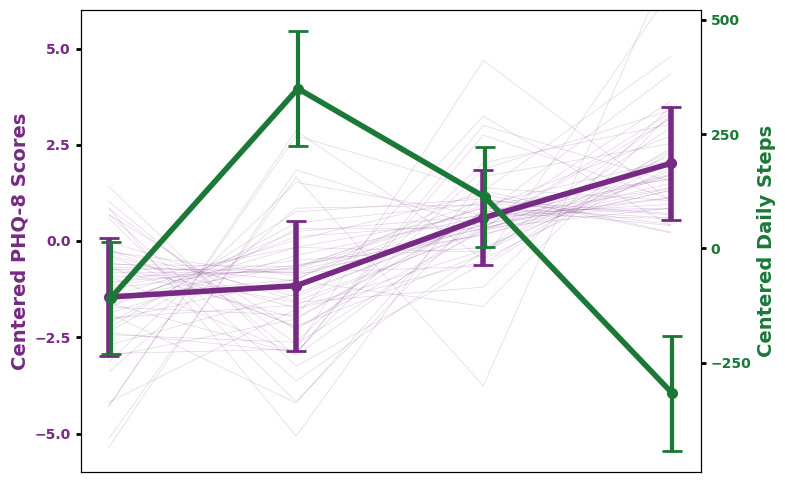

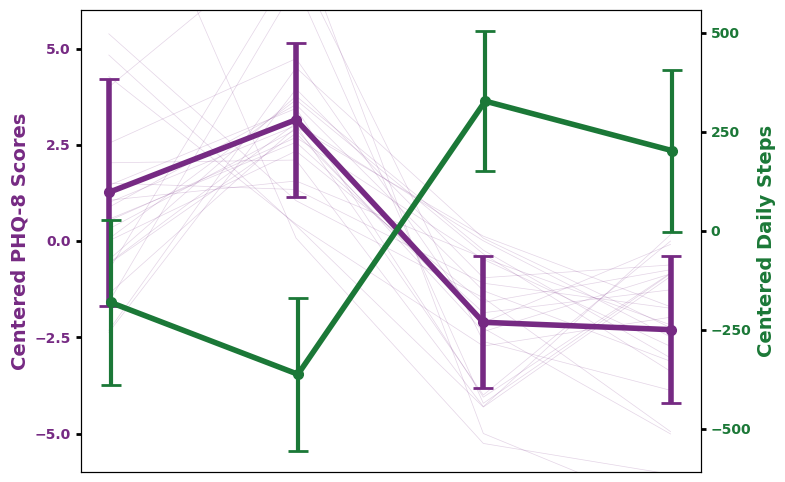

In [19]:
kmean_plot(kcl_set,kcl_step, 4,-6,6)

#### CIBER (Spain)

cluster
2    55
1    15
3    11
0     9
Name: count, dtype: int64


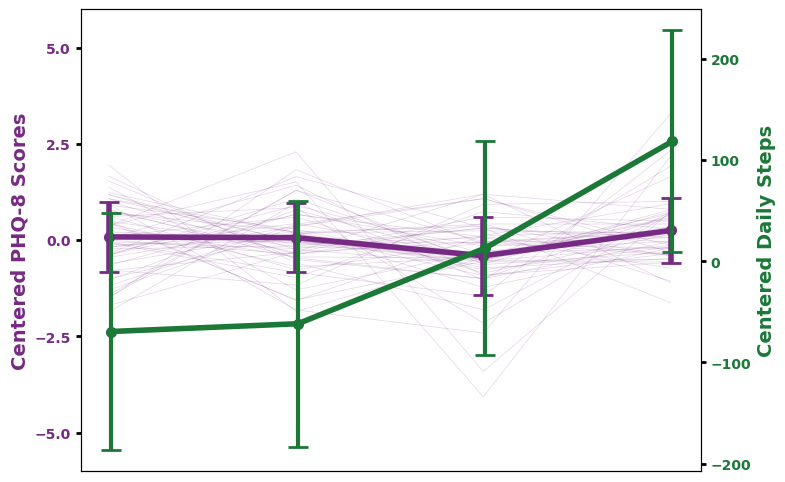

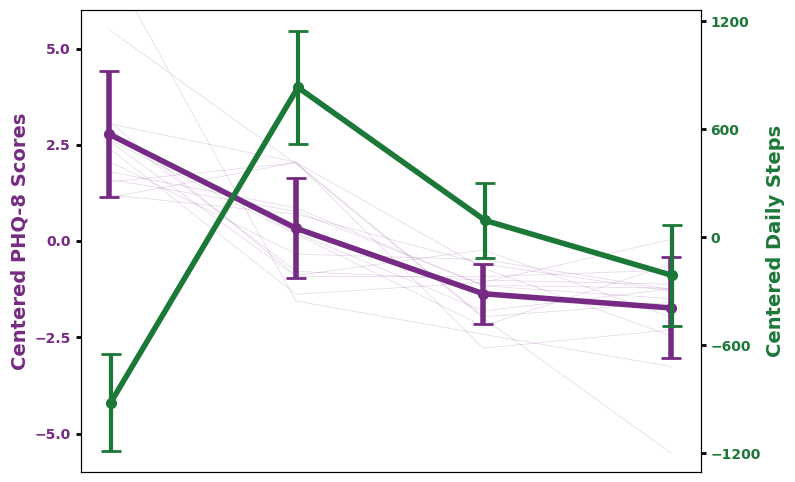

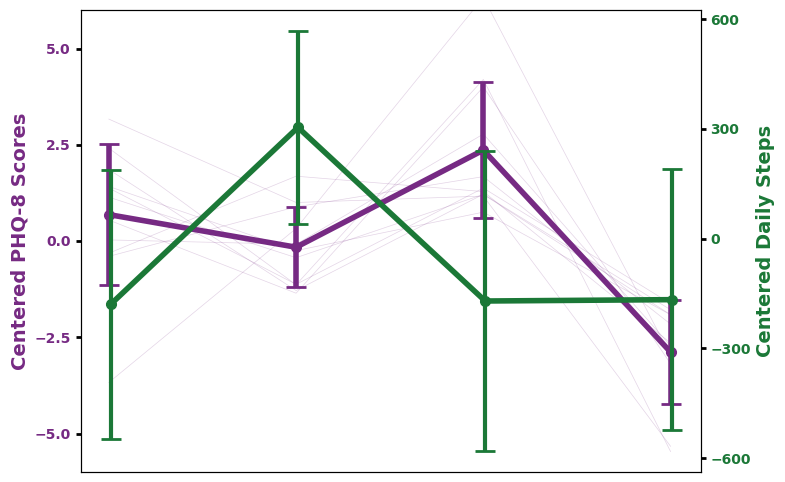

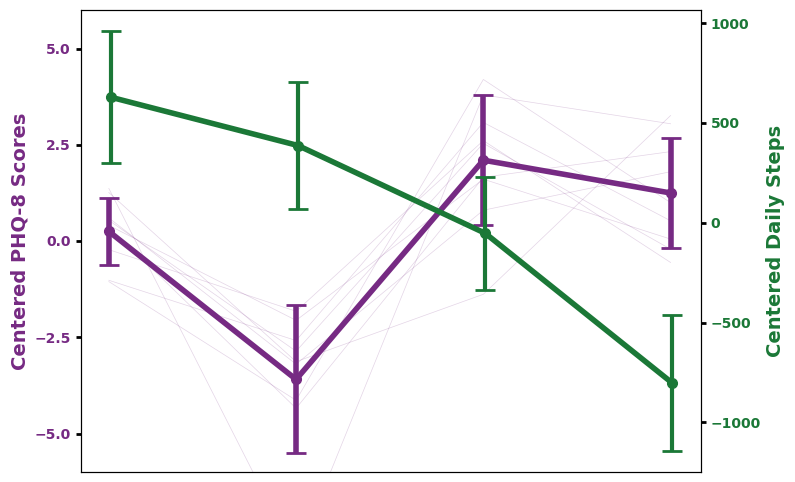

In [20]:
kmean_plot(ciber_set,ciber_step, 4,-6,6)

#### VUMC (Netherlands)

cluster
2    36
1    29
0    22
Name: count, dtype: int64


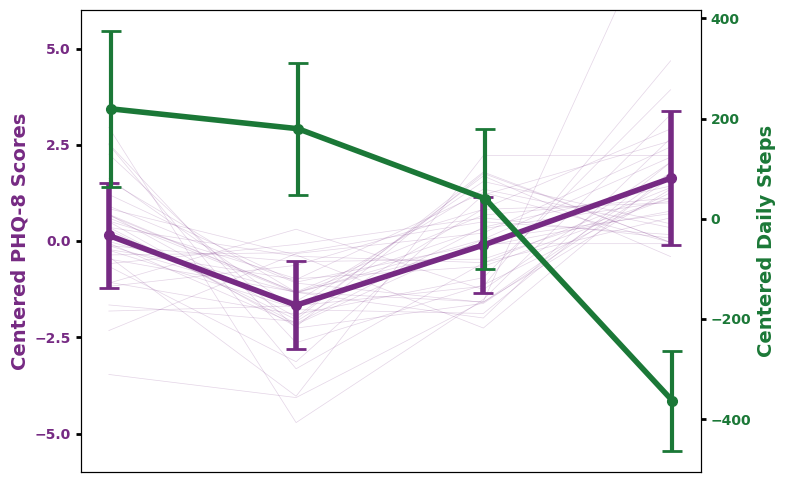

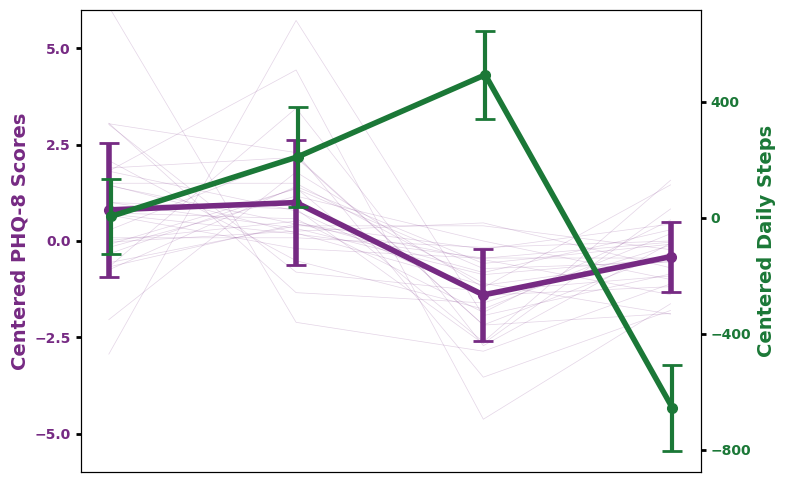

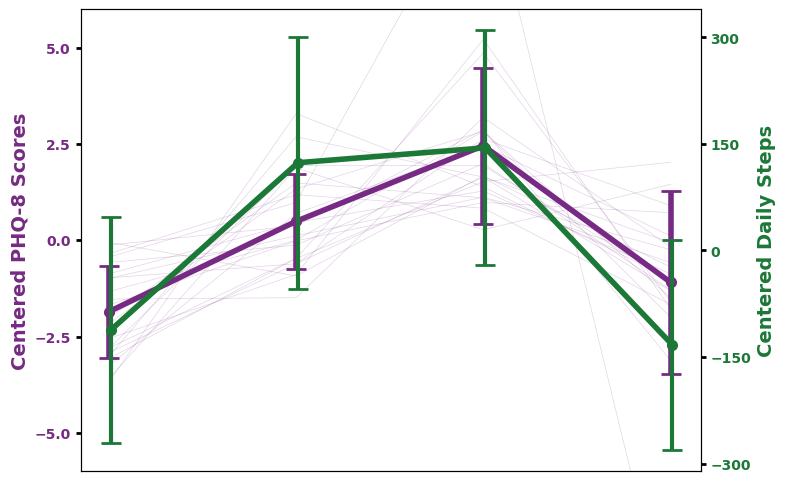

In [21]:
kmean_plot(vumc_set,vumc_step, 3,-6,6)